## Семинар 7: "Методы оптимизации"

ФИО: Дегтярев Роман Олегович

In [213]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from __future__ import division
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

%matplotlib inline

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

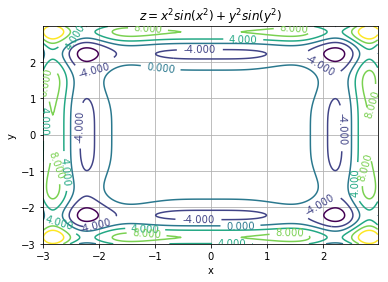

In [2]:
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-3.0, 3.0, delta)
X, Y = np.meshgrid(x, y)

Z = (X**2 *np.sin(X**2) + Y**2 *(np.sin(Y**2)))

plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)
plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.title('$z = x^2 sin(x^2)+y^2 sin (y^2)$')

In [138]:
def plot(func_data, points, choice_f=3, choice_m = 'GD'):
    fig, ax1 = plt.subplots(figsize=(8, 5), 
                        subplot_kw={'projection': '3d'})

    alpha = 10
    r = np.linspace(-alpha,alpha, 15)
    X,Y= np.meshgrid(r,r)
    
    if choice_f == 1:
        l = X**2 + Y**2
        ax1.set_zlabel('$z = x^2 +y^2 $')
    if choice_f == 2:
        l = X**2* np.sin(X) + Y**2 * np.sin(Y)
        ax1.set_zlabel('$z = x^2 sin(x)+y^2 sin (y)$')
    if choice_f == 3:
        l = X**2* np.sin(X**2) + Y**2 * np.sin(Y**2)
        ax1.set_zlabel('$z = x^2 sin(x^2)+y^2 sin (y^2)$')
        
    if choice_m == 'GD':
        ax1.set_title('GD')
    if choice_m == 'Momentum':
        ax1.set_title('Momentum')
    if choice_m == 'NAG':
        ax1.set_title('NAG')
    if choice_m == 'Adagrad':
        ax1.set_title('Adagrad')
    if choice_m == 'Adadelta':
        ax1.set_title('Adadelta')
    if choice_m == 'Adam':
        ax1.set_title('Adam')
    
    
    
    ax1.scatter(np.array(points)[:,0][::10], np.array(points)[:,1][::10], func_data[::10], c='red')
    ax1.plot_wireframe(X,Y,l)
    plt.show()

In [149]:
def plot_opt(fs, gs, title):
    plt.figure(figsize=(16, 5))
    plt.title(title, fontsize=16)
    plt.plot(fs, label = 'f(x)')
    plt.plot(gs, label = 'grad_f(x)')
    plt.legend()
    plt.show()

In [4]:
def GD(func, grad, X, lr=1e-3, eps=1e-5):
    fs = []
    gs = []
    points = []
    while np.abs(np.linalg.norm(grad(X))) > eps:
        X = X - lr * grad(X)
        points.append(X)
        fs.append(func(X))
        gs.append(grad(X))
    return fs, gs, points

In [5]:
def Momentum(func, grad, X, lr=1e-3, eps = 1e-5, gamma = 0.9):
    fs = []
    gs = []
    points = []
    nu = np.ones(X.shape)*eps
    while np.abs(np.linalg.norm(grad(X))) > eps:
        nu = nu*gamma + lr * grad(X)
        X = X - nu
        points.append(X)
        fs.append(func(X))
        gs.append(grad(X))
    return fs, gs, points

In [6]:
def NAG(func, grad, X, lr=1e-3, eps = 1e-5, gamma = 0.9):
    fs = []
    gs = []
    points = []
    nu = np.ones(X.shape)*eps
    while np.abs(np.linalg.norm(grad(X))) > eps:
        nu = nu*gamma + lr*grad(X - gamma*nu)
        X = X - nu
        points.append(X)
        fs.append(func(X))
        gs.append(grad(X))
    return fs, gs, points

In [7]:
def Adagrad(func, grad, X, lr=0.1, eps=1e-5):
    fs = []
    gs = []
    points = []
    grad_sum = eps * np.ones(X.shape)
    while np.abs(np.linalg.norm(grad(X))) > eps:
        grad_sum += np.square(grad(X)+eps)
        X = X - lr * (np.divide(grad(X), np.sqrt(grad_sum)))
        points.append(X)
        fs.append(func(X))
        gs.append(grad(X))
    return fs, gs, points

In [146]:
def Adadelta(func, grad, X, eps = 1e-5, gamma = 0.9):
    fs = []
    gs = []
    points = []
    nge = eps * np.ones(X.shape)
    pge = eps * np.ones(X.shape)
    dX = eps * np.ones(X.shape)
    while np.abs(np.linalg.norm(grad(X))) > eps:
        nge = gamma * nge + (1 - gamma)* np.square(grad(X))
        rmn = np.sqrt(nge)
        pge = gamma * pge + (1 - gamma) * dX
        rmp = np.sqrt(abs(pge))
        dX = np.divide(rmp, rmn+eps)
        dX = np.multiply(dX, grad(X))
        X = X - dX
        points.append(X)
        fs.append(func(X))
        gs.append(grad(X))    
    return fs, gs, points

In [44]:
def Adam(func, grad, X, lr =0.1, betta1 = 0.9, betta2 = 0.999, eps = 1e-8):
    fs = []
    gs = []
    points = []
    m = eps * np.ones(X.shape)
    nu = eps * np.ones(X.shape)
    while np.abs(np.linalg.norm(grad(X))) > eps:
        m = betta1*m +(1 - betta1)*grad(X)
        nu = betta2*nu +(1 - betta2)*np.square(grad(X))
        m_ = m/(1-betta1)
        nu_ = nu/(1-betta2)
        nu_ = np.sqrt(nu_+eps)
        X = X - lr*np.divide(m_, nu_)
        points.append(X)
        fs.append(func(X))
        gs.append(grad(X))    
    return fs, gs, points 

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [157]:
X = 15 * np.array(np.random.random_sample(2))
X

array([ 4.32139897,  8.321924  ])

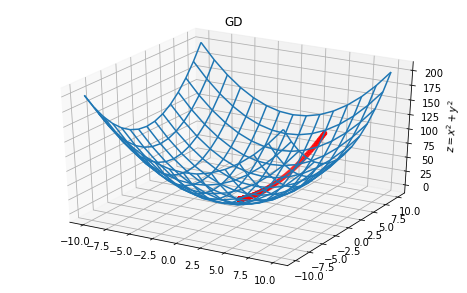

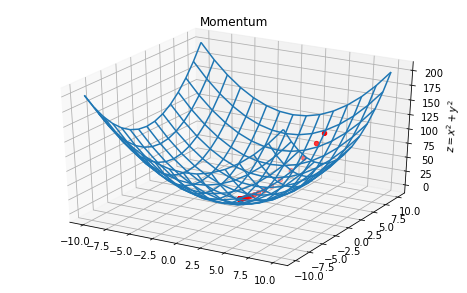

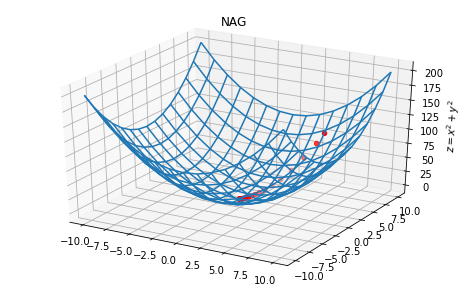

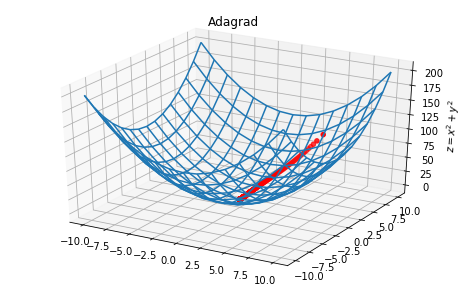

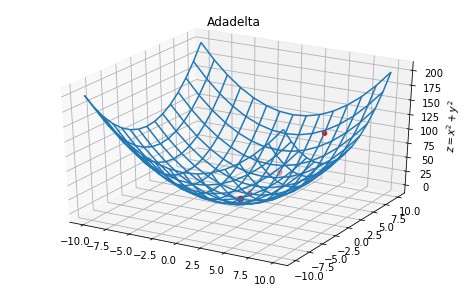

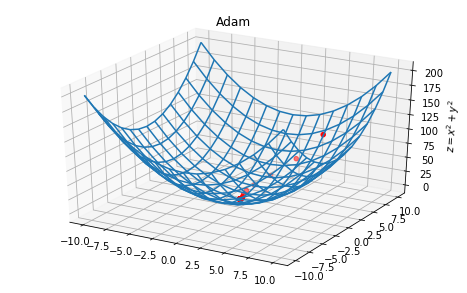

In [158]:
fun = lambda X: X[0] ** 2 + X[1] ** 2
grad_fun = lambda X: np.array([2.*X[0], 2.*X[1]])

function, gradient, points  = GD(fun, grad_fun, X)
plot(function, points, choice_f=1, choice_m='GD')

function, gradient, points  = Momentum(fun, grad_fun, X)
plot(function, points, choice_f=1, choice_m='Momentum')

function, gradient, points  = NAG(fun, grad_fun, X)
plot(function, points, choice_f=1, choice_m='NAG')

function, gradient, points  = Adagrad(fun, grad_fun, X)
plot(function, points, choice_f=1, choice_m='Adagrad')

function, gradient, points  = Adadelta(fun, grad_fun, X)
plot(function, points, choice_f=1, choice_m='Adadelta')

function, gradient, points  = Adam(fun, grad_fun, X)
plot(function, points, choice_f=1, choice_m='Adam')

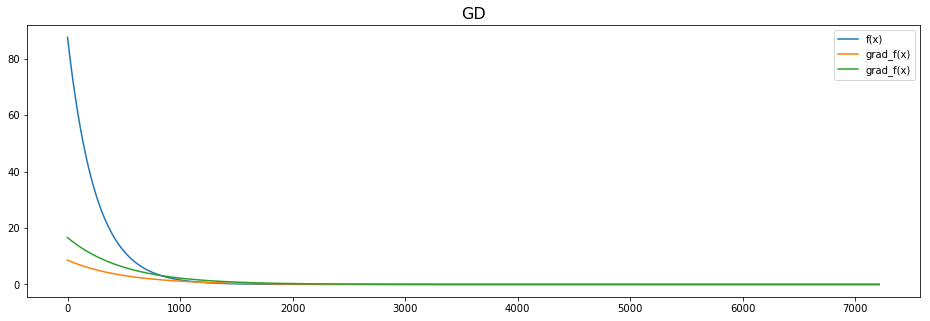

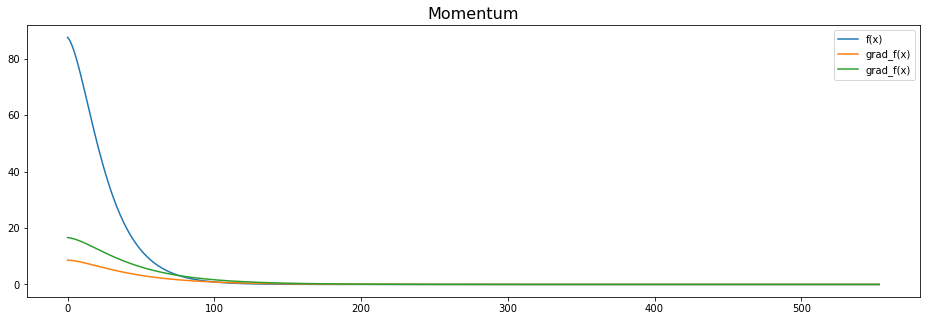

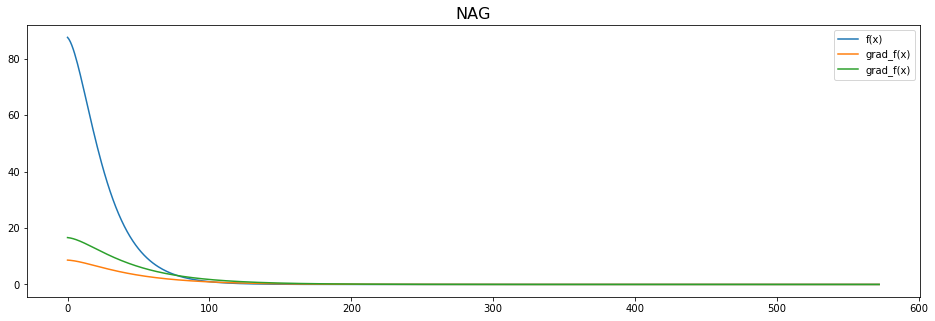

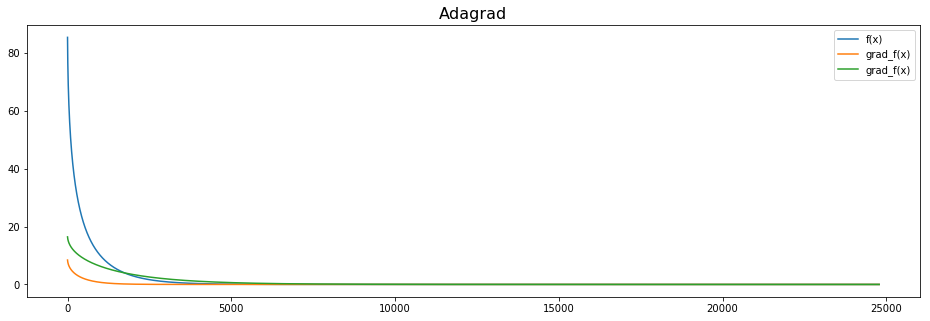

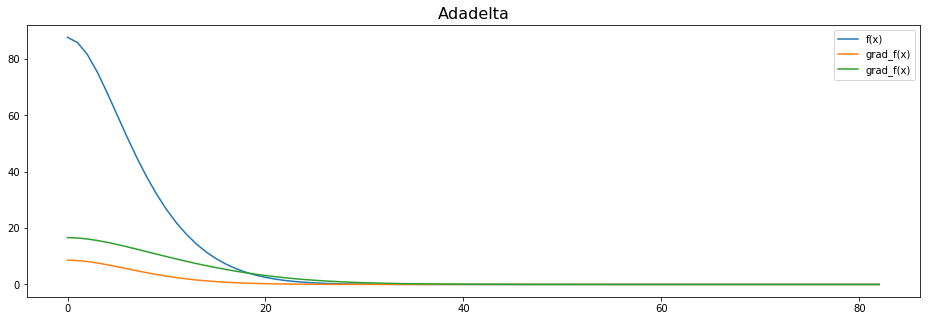

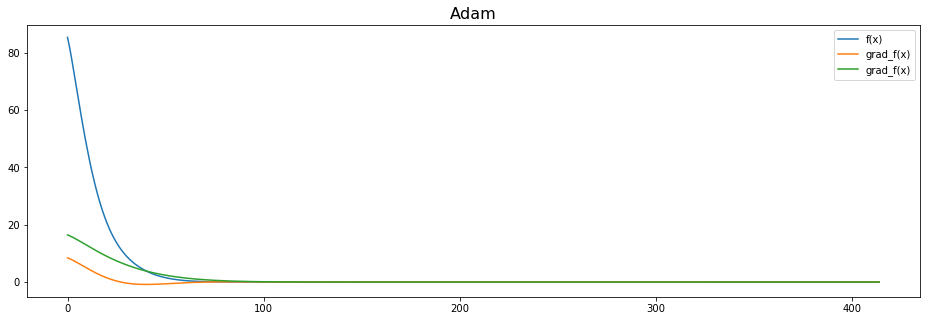

In [159]:
function, gradient, points  = GD(fun, grad_fun, X)
plot_opt(function, gradient, 'GD')

function, gradient, points  = Momentum(fun, grad_fun, X)
plot_opt(function, gradient, 'Momentum')

function, gradient, points  = NAG(fun, grad_fun, X)
plot_opt(function, gradient, 'NAG')

function, gradient, points  = Adagrad(fun, grad_fun, X)
plot_opt(function, gradient, 'Adagrad')

function, gradient, points  = Adadelta(fun, grad_fun, X)
plot_opt(function, gradient, 'Adadelta')

function, gradient, points  = Adam(fun, grad_fun, X)
plot_opt(function, gradient, 'Adam')

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [168]:
X = 5 * np.array(np.random.random_sample(2))

In [169]:
fun = lambda X: np.power(X[0], 2) * np.sin(X[0]) + np.power(X[1], 2) * np.sin(X[1])
grad_fun = lambda X: np.array([2.*X[0]*np.sin(X[0]) + np.power(X[0], 2) * np.cos(X[0]), 
                               2.*X[1]*np.sin(X[1]) + np.power(X[1], 2) * np.cos(X[1])])

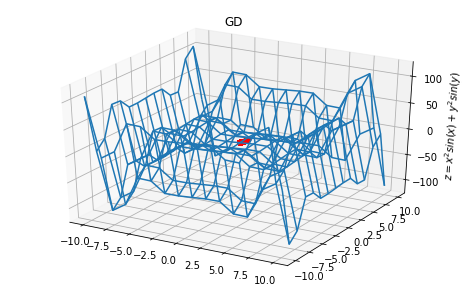

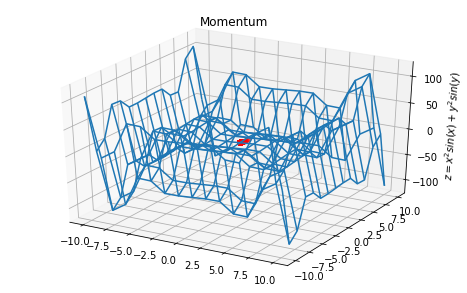

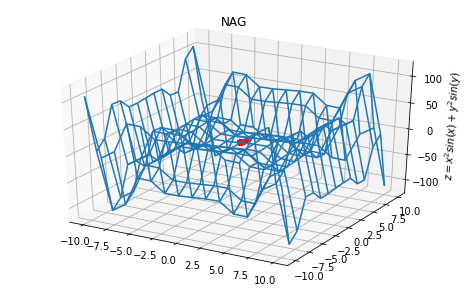

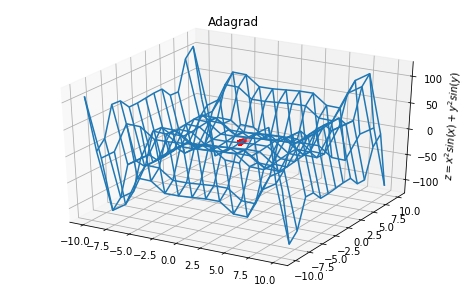

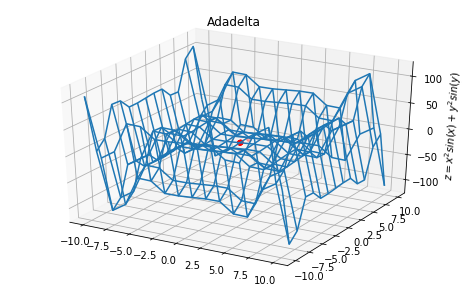

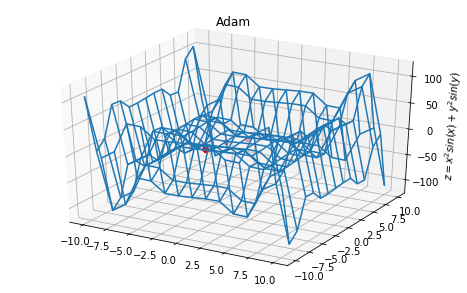

In [170]:
function, gradient, points  = GD(fun, grad_fun, X)
plot(function, points, choice_f=2, choice_m='GD')

function, gradient, points  = Momentum(fun, grad_fun, X)
plot(function, points, choice_f=2, choice_m='Momentum')

function, gradient, points  = NAG(fun, grad_fun, X)
plot(function, points, choice_f=2, choice_m='NAG')

function, gradient, points  = Adagrad(fun, grad_fun, X)
plot(function, points, choice_f=2, choice_m='Adagrad')

function, gradient, points  = Adadelta(fun, grad_fun, X)
plot(function, points, choice_f=2, choice_m='Adadelta')

function, gradient, points  = Adam(fun, grad_fun, X)
plot(function, points, choice_f=2, choice_m='Adam')

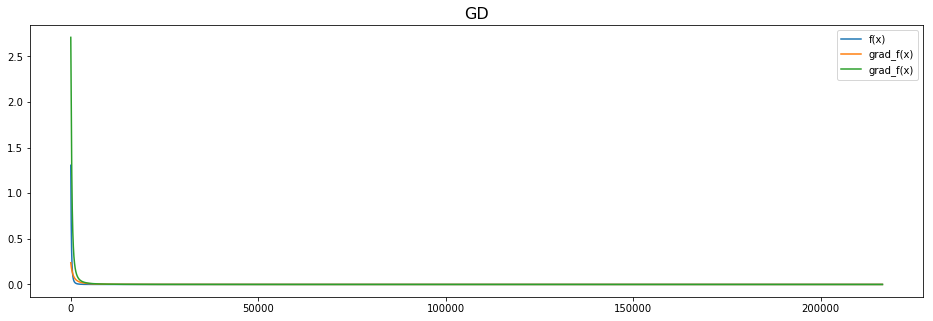

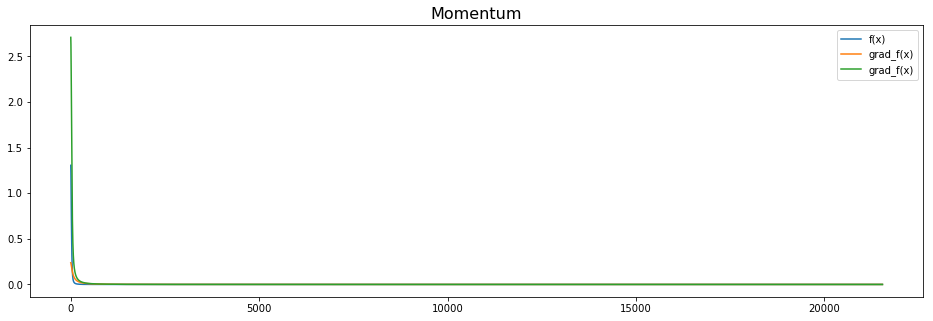

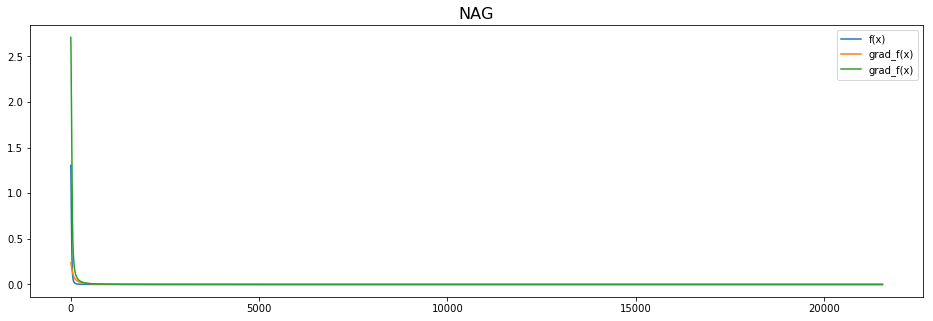

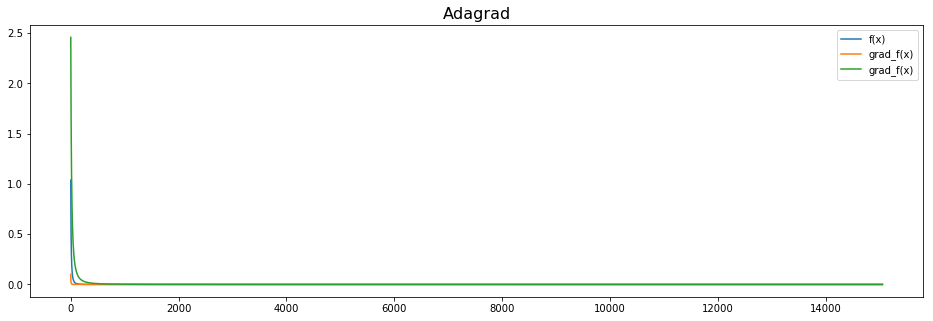

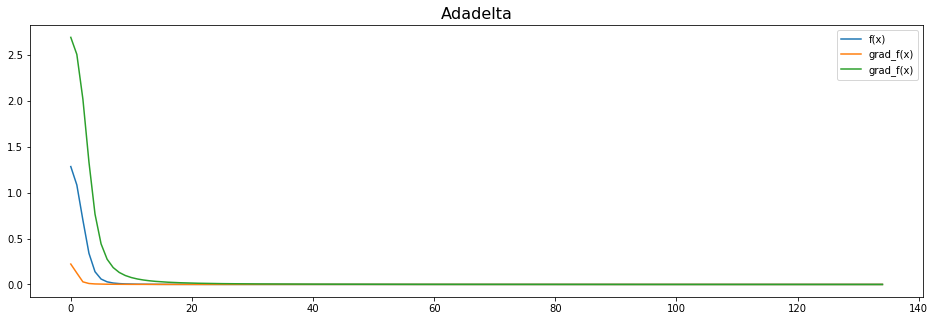

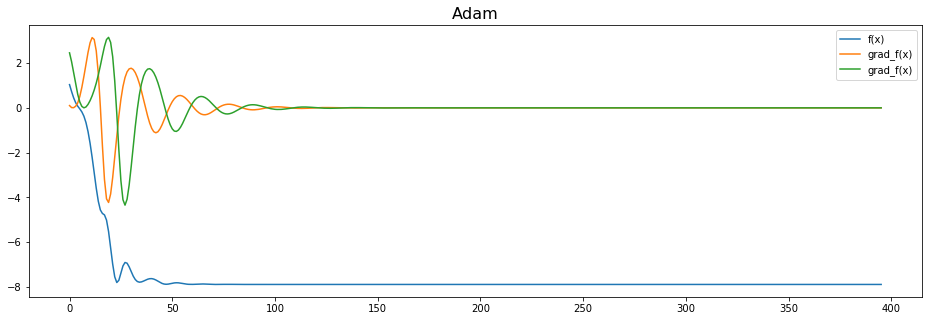

In [171]:
function, gradient, points  = GD(fun, grad_fun, X)
plot_opt(function, gradient, 'GD')

function, gradient, points  = Momentum(fun, grad_fun, X)
plot_opt(function, gradient, 'Momentum')

function, gradient, points  = NAG(fun, grad_fun, X)
plot_opt(function, gradient, 'NAG')

function, gradient, points  = Adagrad(fun, grad_fun, X)
plot_opt(function, gradient, 'Adagrad')

function, gradient, points  = Adadelta(fun, grad_fun, X)
plot_opt(function, gradient, 'Adadelta')

function, gradient, points  = Adam(fun, grad_fun, X)
plot_opt(function, gradient, 'Adam')

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [141]:
X = 10 * np.array(np.random.random_sample(2))
X

fun = lambda X: np.power(X[0], 2) * np.sin(np.power(X[0], 2)) + np.power(X[1], 2) * np.sin(np.power(X[1], 2))
grad_fun = lambda X: np.array([2.*X[0]*np.sin(np.power(X[0], 2)) + 2.*np.power(X[0], 3) * np.cos(np.power(X[0], 2)),
                               2.*X[1]*np.sin(np.power(X[1], 2)) + 2.*np.power(X[1], 3) * np.cos(np.power(X[1], 2))])

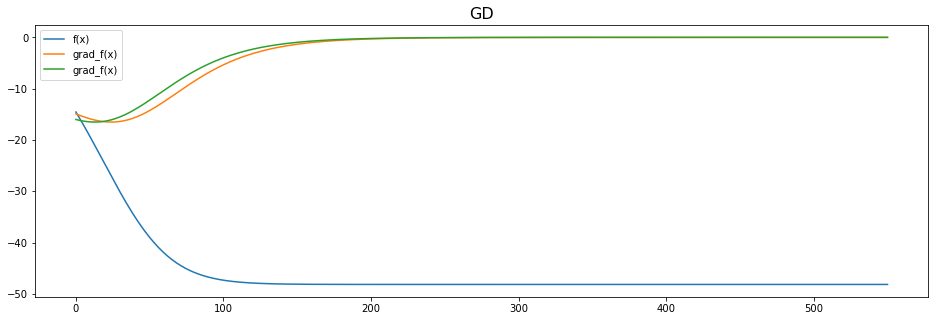

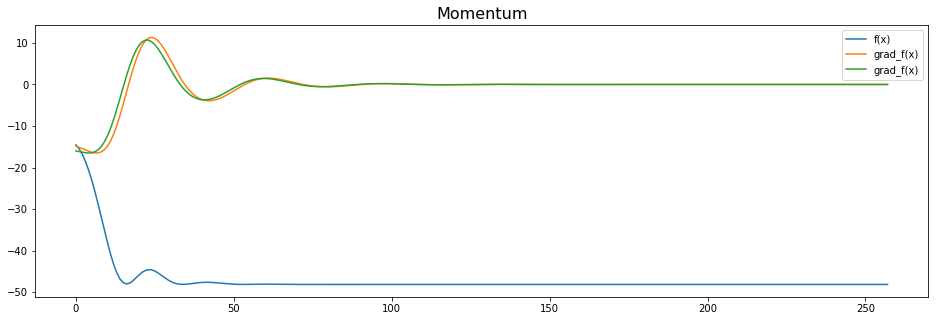

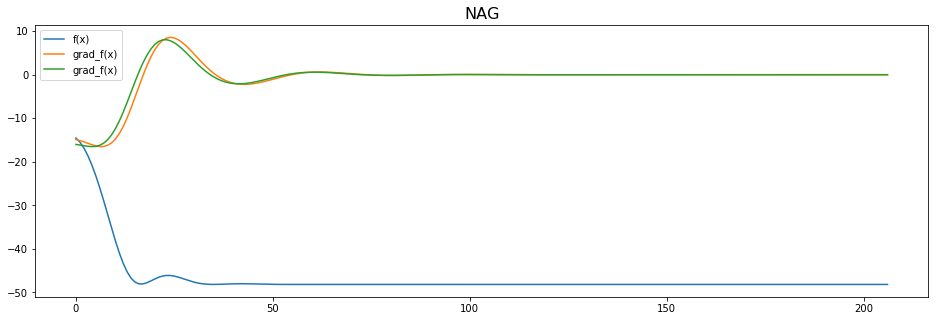

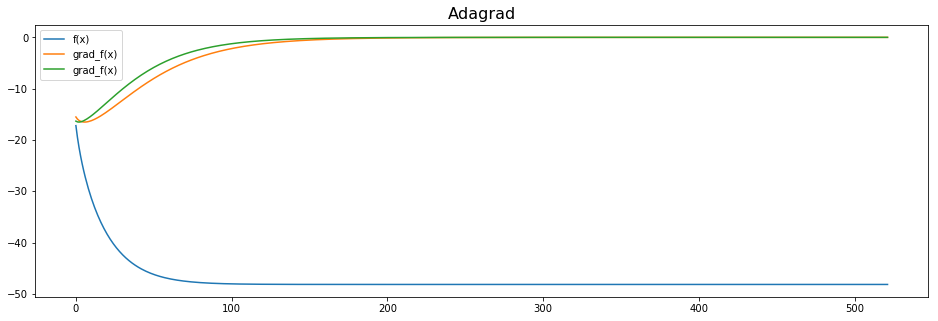

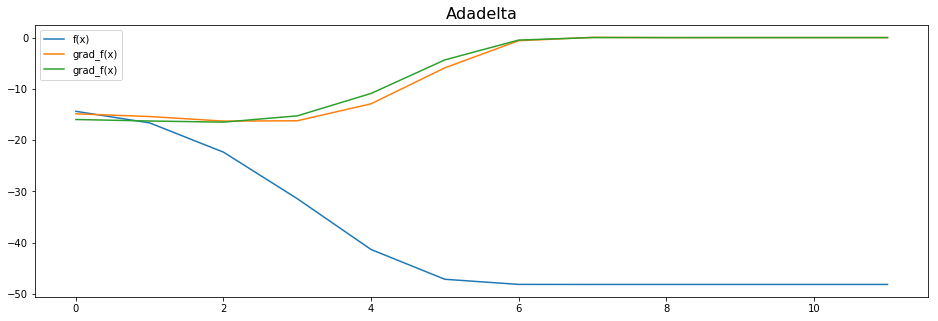

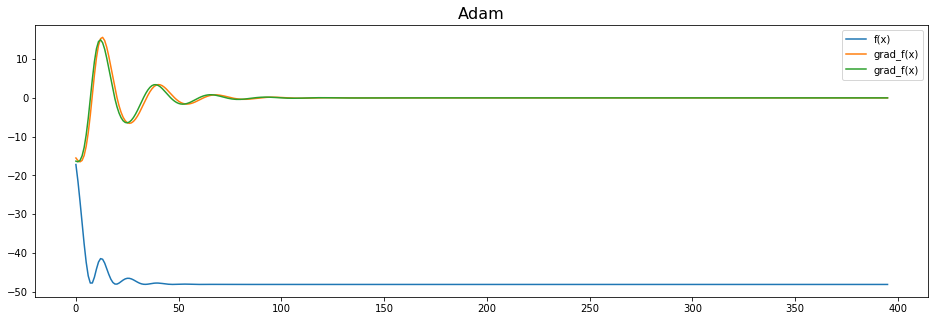

In [148]:
function, gradient, points  = GD(fun, grad_fun, X)
plot_opt(function, gradient, 'GD')

function, gradient, points  = Momentum(fun, grad_fun, X)
plot_opt(function, gradient, 'Momentum')

function, gradient, points  = NAG(fun, grad_fun, X)
plot_opt(function, gradient, 'NAG')

function, gradient, points  = Adagrad(fun, grad_fun, X)
plot_opt(function, gradient, 'Adagrad')

function, gradient, points  = Adadelta(fun, grad_fun, X)
plot_opt(function, gradient, 'Adadelta')

function, gradient, points  = Adam(fun, grad_fun, X)
plot_opt(function, gradient, 'Adam')

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, NAG и SGD (на MNIST). </i>

In [276]:
#Parameters:
_LR = 0.01
_BATCH_SIZE = 32
_EPOCH = 15
_EPS=1.00000e-02
_RAND_STATE = 42

In [277]:
#Load MNIST
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('.', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [278]:
#network architecture 
class network_sigmoid(nn.Module):

    def __init__(self):
        super(network_sigmoid, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(784, 100),
            nn.Sigmoid()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(100, _BATCH_SIZE),
            nn.Sigmoid()
        )
        self.fc = nn.Linear(_BATCH_SIZE,10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.fc(out)
        return out

In [279]:
#Adam, NAG? и SGD
loss_train1 = []
loss_train2 = []
loss_func = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(fnn.parameters(), lr=_LR)
optimizer2 = torch.optim.SGD(fnn.parameters(), lr=_LR)

In [280]:
#Adam
fnn = network_sigmoid()
for i in tqdm(range(_EPOCH)):
    for j,[image,label] in enumerate(train_loader):
        image = Variable(image)
        label = Variable(label)
        image = image.view(-1, 28*28)
        optimizer1.zero_grad()
        result = fnn.forward(image)
        loss = loss_func(result,label)
        loss.backward()
        optimizer1.step()
        if (loss.data.numpy()[0]<_EPS):
            break
        
        if j % 1000 == 0:
            loss_train1.append(loss.data.numpy()[0])

100%|██████████| 15/15 [05:50<00:00, 23.39s/it]


In [281]:
#SGD
fnn = network_sigmoid()
for i in tqdm(range(_EPOCH)):
    for j,[image,label] in enumerate(train_loader):
        image = Variable(image)
        label = Variable(label)
        image = image.view(-1, 28*28)
        optimizer2.zero_grad()
        result = fnn.forward(image)
        loss = loss_func(result,label)
        loss.backward()
        optimizer2.step()
        if (loss.data.numpy()[0]<_EPS):
            break
        
        if j % 1000 == 0:
            loss_train2.append(loss.data.numpy()[0])

100%|██████████| 15/15 [04:05<00:00, 16.34s/it]


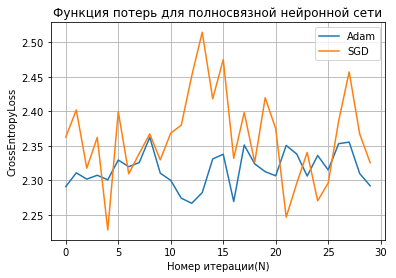

In [282]:
plt.figure()
plt.title(u"Функция потерь для полносвязной нейронной сети")
plt.xlabel(u"Номер итерации(N)")
plt.ylabel(u"CrossEntropyLoss")
plt.grid()
plt.plot(loss_train1, label = "Adam")
plt.plot(loss_train2, label = "SGD")
plt.legend()

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, NAG и SGD. </i>

In [283]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(nn.Conv2d(1, 8, 3), nn.ReLU(), nn.MaxPool2d(2))
        self.layer2 = torch.nn.Sequential(nn.Conv2d(8, 16, 3), nn.ReLU())
        self.layer3 = torch.nn.Sequential(nn.Linear((11)*(11)*16, 10), nn.LogSoftmax())
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(_BATCH_SIZE, -1)
        x = self.layer3(x)
        return x  

In [284]:
#Adam, NAG? и SGD
loss_train1 = []
loss_train2 = []
model = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model.parameters(), lr=_LR)
optimizer2 = torch.optim.SGD(model.parameters(), lr=_LR)

In [285]:
import torchvision.datasets as dset
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [286]:
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size=32,
                                           shuffle=True, 
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=32,
                                          shuffle=False, 
                                          drop_last=True)

In [287]:
#Adam
_break_point = 0.01
model = CNN()
for i in tqdm(range(0,_EPOCH)):
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image)
        y_= Variable(label)
        
        optimizer2.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer2.step()
        if (loss.data.numpy()[0]<_break_point):
            break
        
        if j % 1000 == 0:
            loss_train2.append(loss.data.numpy()[0])

100%|██████████| 15/15 [10:16<00:00, 41.09s/it]


In [288]:
#SGD
_break_point = 0.01
model = CNN()
for i in tqdm(range(0,_EPOCH)):
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image)
        y_= Variable(label)
        
        optimizer1.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer1.step()
        if (loss.data.numpy()[0]<_break_point):
            break
        
        if j % 1000 == 0:
            loss_train1.append(loss.data.numpy()[0])

100%|██████████| 15/15 [11:19<00:00, 45.28s/it]


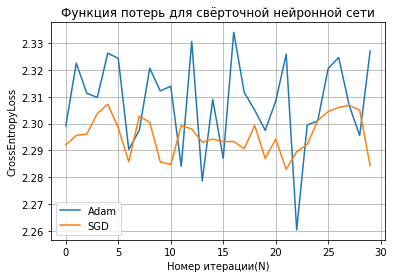

In [289]:
plt.figure()
plt.title(u"Функция потерь для свёрточной нейронной сети")
plt.xlabel(u"Номер итерации(N)")
plt.ylabel(u"CrossEntropyLoss")
plt.grid()
plt.plot(loss_train1, label = "Adam")
plt.plot(loss_train2, label = "SGD")
plt.legend()

# Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: